<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V4</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Что же, теперь причин отправлять тебя на доработку нет. В образовательных целях показал тебе какие ещё были пути устранения бага кроме сброса индексов. Думаю, полезно посмотреть.

И на этом всё. Успехов со сборным проектом!

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
И снова добрый вечер!

Указал тебе на твой недочёт при попытке исправить баг + сразу сказал важную информацию, которая поможет тебе избежать ещё одной доработки. Надеюсь, теперь получится устранить ошибку.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Вроде, понял и исправил, а также обновил вывод. Было 0,6% риск убытка, стало 1,2%
</div>

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Привет ещё раз!

В целом работа хорошая, но есть одна очень неочевидная проблема: баг с индексами в функции прибыли. Я постарался максимально подробно его описать. Надеюсь, проблем с устранением не возникнет.

<div class="alert alert-info">
<font size="4"><b>Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
    Привет, Алексей! Спасибо, что прислал задание :) <br>Меня зовут Никита Сон и я буду проверять твой проект. Предлагаю обращаться друг к другу на ты, как это принято в Практикуме, если ты не против. Но если хочешь на Вы - не буду возражать 🙂
        
Поехали 🚀
    <br />

Мои комментарии обозначены пометкой <b>Комментарий ревьюера</b>. При внесении правок в проект, пожалуйста, не меняй и не удаляй их т.к. дальнейшая проверка будет происходить в том числе на основе того, исправлены замечания в комментариях или нет. Зато ты всегда можешь оставить свои комментарии для меня :)
    </font>
</div>

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
В зелёных блоках будут позитивные комментарии
<br />
    </font>
</div>

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
В жёлтых - некритичные замечания
    </font>
</div>

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
В красных - важные замечания, которые надо обязательно устранить
    </font>
</div>

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
В синих с пиццей - различные нейтральные сообщения, советы на будущее и прочее.
    </font>
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Привет! Прошу прощения, я опасался что такое будет - но надежда была на лучшее. <br>
    В общем, случился какой-то баг, из-за которого у меня всегда восстанавливался автосейв был по состоянию на понедельник. Неважно, пытался ли я сохранить вручную или ждал. Вчера ночью обратил на это внимание (в течении недели я накидывал себе идеи или ещё какие-то вещи, - когда они пропадали ссылался на "ну бывает". Вчера, когда потерял часть работы - задумался, но плюнул и очень быстро все написал "на скорую руку". <br>
    А сейчас случилось опять тоже самое, - т.е. отправилась версия на понедельник. <br>
    Зато после твоего сохранения всё сохранилось, и баг ушёл. <br>
    Прошу прощения за потраченное время!<br>
    Дальше - только на локальной...
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Я взял на себя героическую функцию тестера, пожмякал на кнопку "перезапустить ядро, а затем перезапустить весь блокнот и обратил внимание, что именно после этого автосохранение ломается. <br> И, кажется, plotly.express/plotly.graph_objects  являются причиной... <br>
    Не все герои носят плащи! В техподдержку сообщу попозже...
</div>

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Держал в уме, что какой-то баг возможен. Начало работы было слишком хорошим, чтобы предполагать, что ты запутался )

А плотли - да, убивает ядро и вызывает страдания, у меня из-за него изначально тоже не все комментарии сохранились, пришлось писать заново

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План работы

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона: <br>
 2.1 Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.<br>
 2.2. Обучите модель и сделайте предсказания на валидационной выборке.<br>
 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.<br>
 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.<br>
 2.5. Проанализируйте результаты.<br>
3. Подготовьтесь к расчёту прибыли:<br>
 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.<br>
 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. <br>
 3.3. Напишите выводы по этапу подготовки расчёта прибыли.<br>
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br>
 4.1. Выберите скважины с максимальными значениями предсказаний. <br>
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.<br>
 4.3. Рассчитайте прибыль для полученного объёма сырья.<br>
5. Посчитайте риски и прибыль для каждого региона:<br>
 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.<br>
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.<br>
 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.<br>

### Описание исходных данных

Данные геологоразведки трёх регионов находятся в файлах: <br>
/datasets/geo_data_0.csv.<br>
/datasets/geo_data_1.csv.<br>
/datasets/geo_data_2.csv.<br>
**id** — уникальный идентификатор скважины;<br>
**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);<br>
**product** — объём запасов в скважине (тыс. баррелей).<br>

### Условия задачи

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).<br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br>
Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.<br>
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.<br>

## Загрузка и подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

seed=110923

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Молодец, что решил сразу задать рандом. На будущее учти, что по стандарту PEP8 глобальные константы принято именовать КАПСОМ

### Загрузка и первичное изучение данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [9]:
geo_data_0.duplicated().sum()

0

In [10]:
geo_data_1.duplicated().sum()

0

In [11]:
geo_data_2.duplicated().sum()

0

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Несмотря на то, что нет явных дубликатов, есть повторяющиеся id с разными количественными признаками. Их очень мало, меньше 0.1% данных, но надо понимать: дубликаты могут не быть одинаковыми на все 100% и такое тоже очень желательно обнаруживать.

In [12]:
geo_data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Вывод:** <br>
1. В полученных данных отсутствуют пропуски и дубликаты <br>
2. Столбец 'id' является статистически незначимой, и будет исключена.

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
У нас по ТЗ используется линейная модель, что говорит о том, что нам важно не столкнуться с проблемой мультиколлинеарности, для чего был смысл вычислить корреляции признаков. Этого не хватает твоему EDA

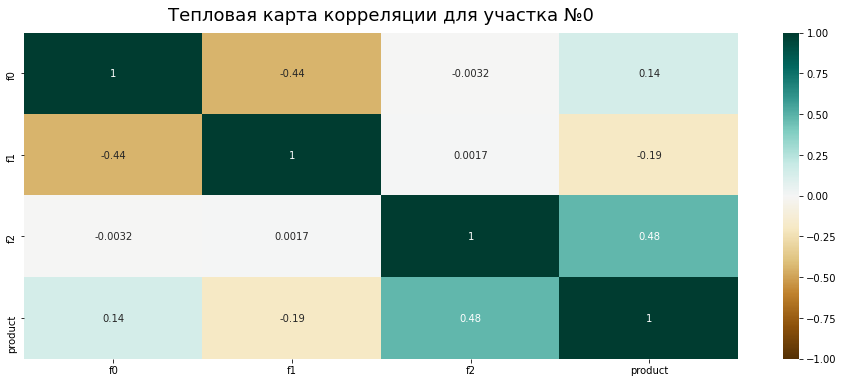

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_0.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №0', fontdict={'fontsize':18}, pad=12); 

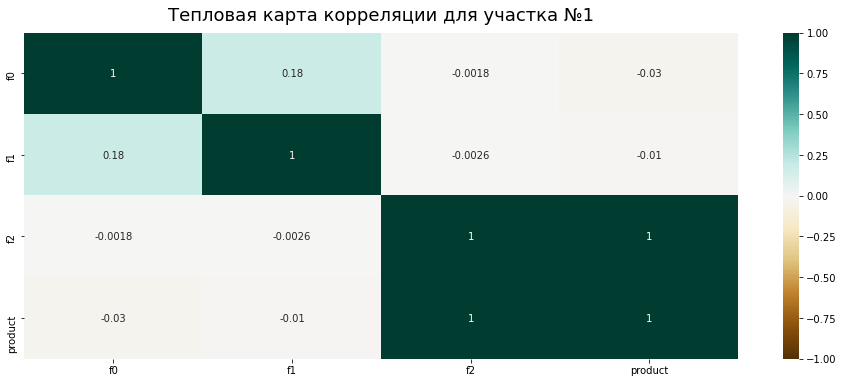

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_1.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №1', fontdict={'fontsize':18}, pad=12); 

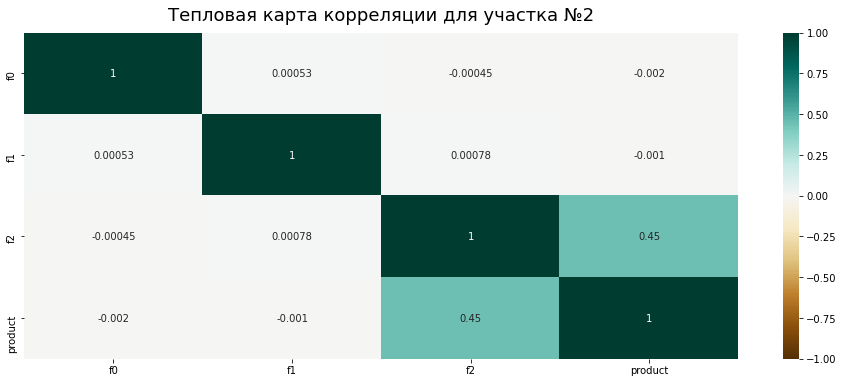

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №2', fontdict={'fontsize':18}, pad=12); 

Следует отметить, что участок №1 единственный имеет 100% корреляцию между параметрами f2 и product.

### Обработка данных и изучение графиков

В соответствии с выводом из прошлого этапа, исключаем id (уникальный идентификатор скважины) из данных. 

In [16]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

In [17]:
#fig_all_product = go.Figure()
#fig_all_product.add_trace(go.Histogram(x=geo_data_0['product'], opacity=0.75, name='Регион №1' ))
#fig_all_product.add_trace(go.Histogram(x=geo_data_1['product'], opacity=0.75, name='Регион №2'))
#fig_all_product.add_trace(go.Histogram(x=geo_data_2['product'], opacity=0.75, name='Регион №3'))
#fig_all_product.update_layout(
#    title="Сводная диаграмма по объему запасов в регионах №1-3",
#    xaxis_title="тыс. баррелей",
#    yaxis_title="количество скважин",
#    legend=dict(x=.5, xanchor="center", orientation="h"),
#    barmode='overlay',
#    margin=dict(l=0, r=0, t=30, b=0))
#fig_all_product.show()

In [18]:
# fig_all_f0 = go.Figure()
# fig_all_f0.add_trace(go.Histogram(x=geo_data_0['f0'], opacity=0.75, name='Регион №1'))
# fig_all_f0.add_trace(go.Histogram(x=geo_data_1['f0'], opacity=0.75, name='Регион №2'))
# fig_all_f0.add_trace(go.Histogram(x=geo_data_2['f0'], opacity=0.75, name='Регион №3'))
# fig_all_f0.update_layout(
#     title="Сводная диаграмма по параметру f0 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f0.show()

In [19]:
# fig_all_f1 = go.Figure()
# fig_all_f1.add_trace(go.Histogram(x=geo_data_0['f1'], opacity=0.75, name='Регион №1'))
# fig_all_f1.add_trace(go.Histogram(x=geo_data_1['f1'], opacity=0.75, name='Регион №2'))
# fig_all_f1.add_trace(go.Histogram(x=geo_data_2['f1'], opacity=0.75, name='Регион №3'))
# fig_all_f1.update_layout(
#     title="Сводная диаграмма по параметру f1 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f1.show()

In [20]:
# fig_all_f2 = go.Figure()
# fig_all_f2.add_trace(go.Histogram(x=geo_data_0['f2'], opacity=0.75, name='Регион №1'))
# fig_all_f2.add_trace(go.Histogram(x=geo_data_1['f2'], opacity=0.75, name='Регион №2'))
# fig_all_f2.add_trace(go.Histogram(x=geo_data_2['f2'], opacity=0.75, name='Регион №3'))
# fig_all_f2.update_layout(
#     title="Сводная диаграмма по параметру f2 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f2.show()

**Вывод:** <br>
Построены сводные гистраграммы по целевому признаку 'product', а также по признакам модели 'f1', 'f2', 'f3'. <br>
Регион №1 и Регион №3 имеют схожее распределение запасов нефти, в то время как как регион №2 имеет более выраженную консолидацию вокруг определенных значений. Форма распределения может быть обусловлена точностью применяемого оборудования, а также человеческим фактором (с т.з. приведение значений к какому-либо стандартному ряду), либо же синтезированными данными <br>

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Я ревьюер простой: вижу гистограммы - пишу зелёный комментарий.

## Обучение и проверка модели

### Разбивка на выборки

In [21]:
def region_split(data, target):
    features = data.drop([target] , axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=seed)
    
    return features_train, features_valid, target_train, target_valid

In [22]:
features_train_reg_00, features_valid_reg_00, target_train_reg_00, target_valid_reg_00 = region_split(geo_data_0, 'product')
features_train_reg_00.head()

,f0,f1,f2
99701,0.939814,-0.567723,6.938562
34706,0.921092,0.172576,7.850818
63952,1.906421,0.345695,3.090109
12089,1.230229,-0.473351,2.888884
43253,0.092268,0.826024,-1.696042


In [23]:
features_train_reg_01, features_valid_reg_01, target_train_reg_01, target_valid_reg_01 = region_split(geo_data_1, 'product')
features_train_reg_01.head()

,f0,f1,f2
99701,9.070010,-9.623002,4.006108
34706,17.428492,-7.908890,4.994175
63952,-2.233210,-3.571078,2.996109
12089,2.116491,-4.081549,4.991937
43253,-10.959806,-7.685558,3.015871


In [24]:
features_train_reg_02, features_valid_reg_02, target_train_reg_02, target_valid_reg_02 = region_split(geo_data_2, 'product')
features_train_reg_02.head()

,f0,f1,f2
99701,-2.902168,3.051963,4.283602
34706,-0.117701,1.214734,5.084269
63952,0.800679,0.820290,1.967258
12089,-3.214595,3.024660,-0.730989
43253,-0.975012,0.175123,5.992615


### Обучение моделей

In [25]:
#модель для нулевого региона
model = LinearRegression()

model.fit(features_train_reg_00, target_train_reg_00)

predicted_reg_00 = model.predict(features_valid_reg_00)

mse_reg_00 = mean_squared_error(target_valid_reg_00, predicted_reg_00)
rmse_reg_00 = mse_reg_00**0.5
reg_00_mean = predicted_reg_00.mean()


In [26]:
#модель для первого региона
model = LinearRegression()

model.fit(features_train_reg_01, target_train_reg_01)

predicted_reg_01 = model.predict(features_valid_reg_01)

mse_reg_01 = mean_squared_error(target_valid_reg_01, predicted_reg_01)
rmse_reg_01 = mse_reg_01**0.5
reg_01_mean = predicted_reg_01.mean()


In [27]:
#модель для второго региона
model = LinearRegression()

model.fit(features_train_reg_02, target_train_reg_02)

predicted_reg_02 = model.predict(features_valid_reg_02)

mse_reg_02 = mean_squared_error(target_valid_reg_02, predicted_reg_02)
rmse_reg_02 = mse_reg_02**0.5
reg_02_mean = predicted_reg_02.mean()


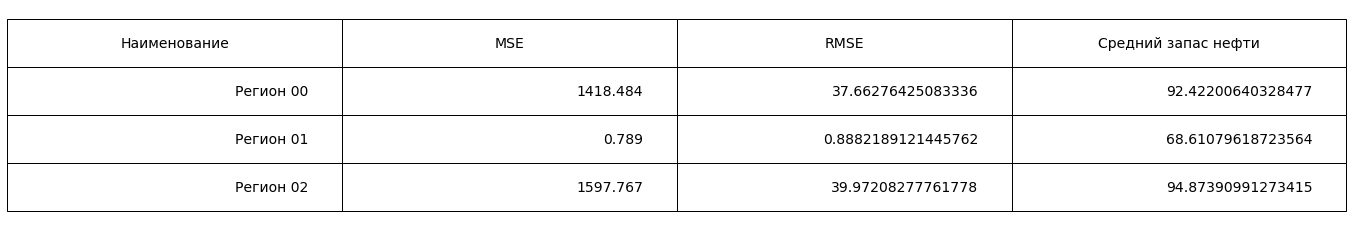

In [28]:
fig, ax = plt.subplots()


table_data=[
  ["Регион 00", round(mse_reg_00, 3), rmse_reg_00, reg_00_mean],
   ["Регион 01", round(mse_reg_01, 3), rmse_reg_01, reg_01_mean],
   ["Регион 02", round(mse_reg_02, 3), rmse_reg_02, reg_02_mean],
]



table = ax.table(cellText=table_data, loc='center',colLabels = ['Наименование', 'MSE', 'RMSE', 'Средний запас нефти'] )

table.set_fontsize (14)
table. scale (4,4)
ax.axis('off')

plt.show() 

Запишем полученные значения дополнительно для дальнейшей работы.

In [29]:
target_valid_reg_00 = pd.Series(target_valid_reg_00)
predicted_reg_00 = pd.Series (predicted_reg_00, index = target_valid_reg_00.index)
target_valid_reg_01 = pd.Series(target_valid_reg_01)
predicted_reg_01 = pd.Series (predicted_reg_01, index = target_valid_reg_01.index)
target_valid_reg_02 = pd.Series(target_valid_reg_02)
predicted_reg_02 = pd.Series (predicted_reg_02, index = target_valid_reg_02.index)

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Получены адекватные модели

## Подготовка к расчёту прибыли

Повторим исходные данные, а также запишем в переменные основные показатели.<br>
При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения выбирают **200 лучших** для разработки.<br>
Бюджет на разработку скважин в регионе — **10 млрд рублей**.<br>
При нынешних ценах один баррель сырья приносит **450 рублей дохода**. Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков нужно оставить лишь те регионы, **в которых вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.<br>

In [30]:
ALL_POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9
ONE_BARREL = 450
BARREL_PRICE = ONE_BARREL*1000


In [31]:
cvp = round(BUDGET  / (BARREL_PRICE * BEST_POINTS), 2)
print('Объем нефти для безубыточности составляет -',cvp, 'тыс. баррелей')

Объем нефти для безубыточности составляет - 111.11 тыс. баррелей


Таким образом, объем нефти для безубыточности превышает *средний* запас нефти по всем точкам в исследуемых регионах. <br>

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Расчёт верный

Для расчета прибыли будем использовать функцию, которая сортирует полученные данные по предсказанному продукту, сортирует и принимает для расчета первые BEST_POINTS = 200 скважин. <br>
После чего, от общей стоимости добытой нефти в данных скважинах отнимает затраты на разработку скважин.

In [32]:
predictions_sorted = predicted_reg_00.sort_values(ascending=False).reset_index(drop = True)

In [33]:
print(predictions_sorted)

0        180.434436
1        176.237396
2        174.121996
3        173.447665
4        172.814088
            ...    
24995     13.653175
24996     12.346765
24997     11.981888
24998     11.838866
24999     11.043417
Length: 25000, dtype: float64


In [34]:
def profit(target, predictions, count):
    predictions.reset_index(drop = True, inplace = True)
    target.reset_index(drop = True, inplace = True)
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]  


    # КОД РЕВЬЮЕРА
    if target[predictions_sorted.index].shape[0] != predictions_sorted.shape[0]:
        print("Shape mismatch!", target[predictions_sorted.index].shape)


    return (BARREL_PRICE*selected.sum()) - BUDGET

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V4</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Ура, баг устранён!<br>

В образовательных целях расскажу тебе какие ещё были варианты решения проблемы:

1. На самом деле, если внимательно посмотреть на нашу задачу, то становится понятно, что переменная target_subsample в функции bootstrap нам не нужна. Фактически она используется только для того, чтобы по её индексам взять сэмпл предсказаний. Но мы можем получить сэмпл предсказаний напрямую:

`pred_subsample = predictions.sample(n=500, replace=True, random_state=state)`

а в функцию расчёта прибыли передать pred_subsample и target (не сэмпл таргетов, а исходный, полный валидационный таргет, 25000 уникальных элементов с неповторяющимися индексами), и тогда получилось бы, что мы сэмплируем предсказания, сортируем их, выбираем 200 лучших, и только после этого по их индексам берём таргеты. Но поскольку таргеты бы были исходные, с уникальными индексами, то запросив один и тот же индекс 2 раза, мы бы в ответ получили 2 одинаковых элемента, а не 4, ошибки бы не было.

2. Можно было бы хранить предсказания и таргеты в одном датафрейме и оперировать бы с ним, а не отдельными его колонками. Тогда вообще не надо было бы делать операцию взятия по индексам: применил .sample() ко всему датафрейму, отсортировал по одной колонке, просуммировал первые 200 значений другой. Всё, элементы одной строки датафрейма между собой жёстко связаны, никакого расхождения не может быть, всё корректно.

Сброс индексов - тоже рабочее решение. Другие решил показать потому что бывает на проблему полезно посмотреть с разных сторон, увидеть разные подходы к решению.

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Давай попробуем разобраться на всё том же микроскопическом искусственном примере:

In [35]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
А теперь, как ты пытался, сбросим индексы предсказаний:

In [36]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False).reset_index(drop = True)


# какие получились индексы:

display(_target.index)
display(_preds.index)

Int64Index([2, 2, 3, 3, 3], dtype='int64')

RangeIndex(start=0, stop=5, step=1)

<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
Там, где ты сбросил - от 0 до 4, логично. А у таргетов остались только двойки и тройки. Как ты можешь из таргетов взять элемент с индексом 0, если его там нет? А что нужно сделать, чтобы был? По-моему, ответ на поверхности: сбросить индексы и у таргетов тоже.

<b>ВАЖНО:</b> у тебя предсказания и таргеты с одинаковыми индексами должны соответствовать друг другу, а если ты сбросишь у предсказаний после сортировки, то соответствия уже не будет. Поэтому надо сбрасывать до сортировки.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
У тебя в функции есть один ну очень неочевидный баг. Настолько неочевидный, что без бутстрапа функция бы была абсолютно корректной, а вот с ним есть нюансы. Я добавил тебе отладочную печать, которая срабатывает, когда у тебя для 500 предсказаний почему-то берётся в расчёт больше, чем 500 таргетов. Явно нежелательное поведение, но печать срабатывает регулярно (смотри ниже). Сейчас покажу из-за чего на небольшом синтетическом примере:

<div class="alert alert-warning">
<font size="4"><b>Комментарий студента V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Не могу понять... по идее, достаточно вписать <br> 
        predictions_sorted = predictions.sort_values(ascending=False).reset_index(drop = True)<br> 
Но при такой постановке код ругается так: <br>
        KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([    0,     1,     2,     3,     4,\n            ...\n            24993, 24995, 24996, 24997, 24998],\n           dtype='int64', length=18829). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike" <br>
        
При этом, во многих источниках написано что reindex и reset_index в целом служат разным целям. Что я делаю не так?

In [37]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

<div class="alert alert-danger">
<font size="4"></font>
    <font size="3", color = "black">
Как так? Почему предсказаний 5, а таргетов аж 13? На самом деле, всё очень просто. На примере элементов с индексом и значением 2. Когда мы попросили у пандаса взять таргеты по индексам предсказаний, и у нас и там и там 2 одинаковых элемента, он отнюдь должен вернуть не 2. Он для каждого запрошенного индекса предсказаний выдаёт все таргеты с таким индексом. Таким образом, мы запросили 2 раза элемента с индексом 2 - оба раза пандас отдал нам 2 таких элемента из таргетов - всего 4 элемента. А если бы у нас было и там, и там по 3 одинаковых элемента, то в итоге было бы 9. Логика, надеюсь, ясна. И вот поэтому почти всегда получается, что когда ты берёшь таргеты по индексам 500 предсказаний, получаешь в итоге более чем 500 таргетов. Благодаря бутстрапу в выборках есть идентичные элементы, с одинаковыми индексами, и они каждый раз вот таким образом "множатся" при вычислении прибыли.

Теперь поговорим о том, как же с этим быть. Ещё один пример:

In [38]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index][:5])

2    3
3    3
4    3
0    2
1    2
dtype: int64

<div class="alert alert-danger">
<font size="4"></font>
    <font size="3", color = "black">
Тут всё корректно, а разница с предыдущим примеров только в том, что индексы одинаковых элементов не одинаковые. То есть для корректности тебе достаточно сделать так, чтобы элементы таргетов и предсказаний остались бы теми же, а индексы бы стали новыми, неповторяющимися. Это можно сделать с помощью метода .reset_index(), указав туда параметр drop=True

In [39]:
print (f'Прибыль от {BEST_POINTS} лучших точек региона 0:',
       "{:8.2f}".format(profit(target_valid_reg_00,predicted_reg_00,BEST_POINTS)/10e5), 'млн. рублей')
print (f'Прибыль от {BEST_POINTS} лучших точек региона 1:', 
       "{:8.2f}".format(profit(target_valid_reg_01,predicted_reg_01,BEST_POINTS)/10e5), 'млн. рублей')
print (f'Прибыль от {BEST_POINTS} лучших точек региона 2:', 
       "{:8.2f}".format(profit(target_valid_reg_02,predicted_reg_02,BEST_POINTS)/10e5), 'млн. рублей')


Прибыль от 200 лучших точек региона 0:  3215.35 млн. рублей
Прибыль от 200 лучших точек региона 1:  2415.09 млн. рублей
Прибыль от 200 лучших точек региона 2:  2207.84 млн. рублей


Регион №0 (geo_data_0) на текущий момент показывает наилучшие результаты, но при этом прибыльная добыча возможна во всех регионах.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Вывод, что каждый регион имеет потенциальную прибыль, на самом деле, для нас очень важен.<br>

Дело в том, что на текущем этапе, когда мы ещё не знаем что получится с помощью бутстрапа, мы уже можем оценить насколько хорошая картина нас может ждать. Ранее мы сравнили средние запасы регионов с точкой безубыточности, и увидели, что каждый регион в среднем убыточен. Если бы мы и здесь увидели убытки, то дальнейшая работа была бы бессмысленной. Зачем нам что-то считать, если у нас даже в лучшем случае убыток? А раз у нас возможна прибыль, то смысл есть, мы делаем качественную осмысленную работу, наша модель для бизнеса может быть полезна.<br>

В реальных проектах важно как можно раньше понять движемся ли мы в верном направлении или надо что-то менять. Потому что тратить время и деньги впустую - не лучшая затея.

## Расчёт прибыли и рисков 

In [40]:
def bootstrap(target, predictions):
    state = np.random.RandomState(110923)
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state = state)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample,200))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)

    mean = values.mean()
    risk = (values < 0).mean()*100
    

    print('95% доверительный интервал:', 
          "{:8.2f}".format(lower/10e5), 'млн. руб. -'
          "{:8.2f}".format(higher/10e5), 'млн. руб.')
    print("Средняя прибыль:", 
          "{:8.2f}".format(mean/10e5), 'млн. руб.')
    print(f'Риск убытка: {risk}%')
    
    values.hist(figsize=(20, 5), bins=30)
    plt.axvline(lower, color='red')
    plt.axvline(higher, color='green')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', 
                'Распределение прибыли'])
    plt.xlabel('Прибыль, руб.')
    plt.ylabel(f'Количество скважин из {BEST_POINTS}')
    plt.title(f'Распределение прибыли')
    plt.show()
    

95% доверительный интервал:   -62.76 млн. руб. -  909.09 млн. руб.
Средняя прибыль:   437.43 млн. руб.
Риск убытка: 4.5%


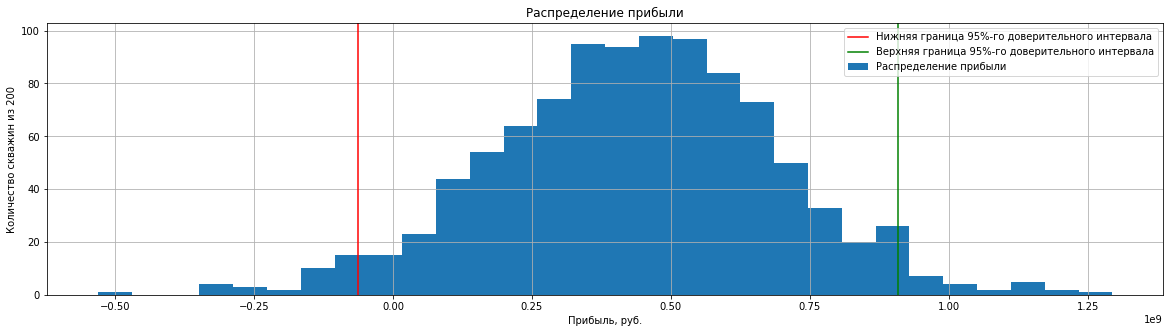

In [41]:
bootstrap(target_valid_reg_00, predicted_reg_00)

95% доверительный интервал:    45.28 млн. руб. -  840.86 млн. руб.
Средняя прибыль:   438.83 млн. руб.
Риск убытка: 1.2%


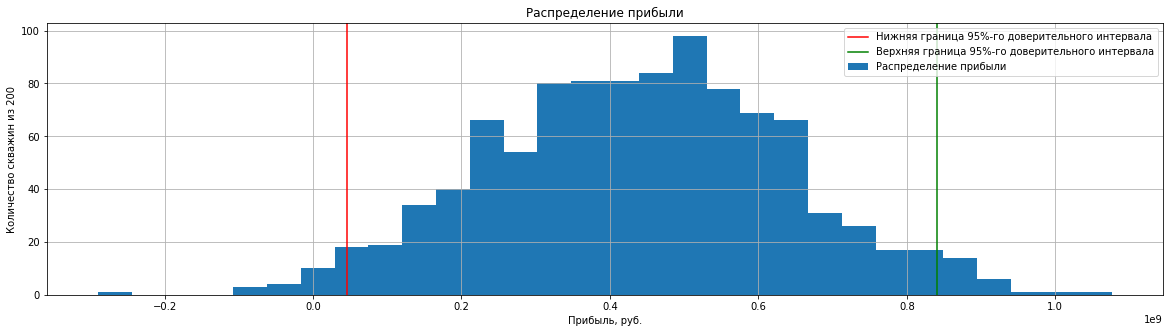

In [42]:
bootstrap(target_valid_reg_01, predicted_reg_01)

95% доверительный интервал:  -148.85 млн. руб. -  913.36 млн. руб.
Средняя прибыль:   397.29 млн. руб.
Риск убытка: 7.5%


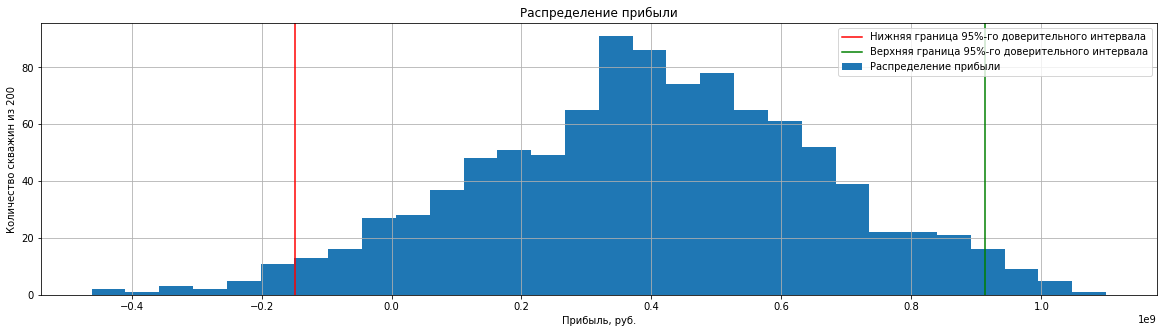

In [43]:
bootstrap(target_valid_reg_02, predicted_reg_02)

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Финальные результаты было бы неплохо визуализировать, ведь они - то, ради чего вся работа делалась. Для этого подойдут ящики с усами или гистограммы распределений выборочных прибылей с нанесёнными на них границами найденных дов. интервалов.

<div class="alert alert-warning">
<font size="4"><b>Комментарий студента V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Дополнил. На этот раз - без Плотли... А вот с расчетом прибыли - не получается почему-то сбросить. вопрос задал выше..

## Вывод

В ходе выполнения работы были выполнены следующие мероприятия:
1. Загружены данные для трех регионов исследования
2. Изучены данные, был исключен малоинформативный столбец 'id'
3. Подготовлены данные (разбиты в соотношении 75:25), обучена модель с выводом среднего запаса предсказанного сырья и RMSE модели.
4. Написана функция подсчета прибыли, а также были сохранены константы в переменные
5. Были определены 200 скважин с наилучшими результатами, подсчитана максимальная прибыль.
6. Использовали Bootstrap с 1000 выборки, для определения возможного распределения прибыли, средней прибылью, а также вероятностью убытка.

## Вывод по цели исследования

Наилучшими показателями обладает регион №1 (geo_data_1) со следующими параметрами:
1. 95% доверительный интервал:    45.28 млн. руб. -  840.86 млн. руб.
2. Средняя прибыль:   438.83 млн. руб.
3. Риск убытка: 1.2%

Из всех рассмотренных регионов, только этот регион имеет риски убытка ниже заданных.

Вместе с тем, следует отметить следующие факторы:
1. Подозрительное распределение данных (консолидация вокруг определенных значений, без разбросов)
2. 100% корреляция между 'product' и 'f2'.
3. При всех пунктах, он имеет наименьший средний предсказанный запас.

В соответствии с вышесказанным, при условиях повторной проверки корректности данных по региону №1, он является единственным, подходящим под условия задачи.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Обычно, если от студента приходит недоделанная работа, то есть вопросы на тему его непонимания происходящего, а у тебя нет. Так что я не знаю как реагировать. Но проект, конечно, надо доделывать, как иначе?

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Реакция 'Лавров.jpg' тут была бы уместна! Я выше объяснил происходящее.
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован